## Imports

In [284]:
import kaggle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, sys, datetime, shlex, subprocess, json, pathlib
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency

## Loads

In [285]:
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

## Overview

In [286]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## NaN value

In [287]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Number unique values and types

In [288]:
pd.DataFrame({"dtype": df_train.dtypes, "unique_values": df_train.nunique()})

,dtype,unique_values
PassengerId,object,8693
HomePlanet,object,3
CryoSleep,object,2
Cabin,object,6560
Destination,object,3
Age,float64,80
VIP,object,2
RoomService,float64,1273
FoodCourt,float64,1507
ShoppingMall,float64,1115


## Check Transported / CryoSleep

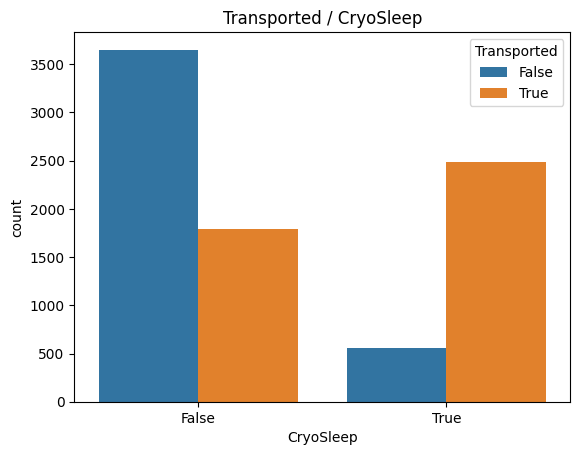

In [289]:
sns.countplot(data=df_train, x='CryoSleep', hue='Transported')
plt.title("Transported / CryoSleep")
plt.show()

## Check VIP / Cabin

In [290]:
nb_vip_no_cabin = df_train[(df_train['VIP'] == True) & (df_train['Cabin'].isna())].shape[0]
print("Number of VIP passengers without a cabin :", nb_vip_no_cabin)

Number of VIP passengers without a cabin : 6


## Check HomePlanet / Transported

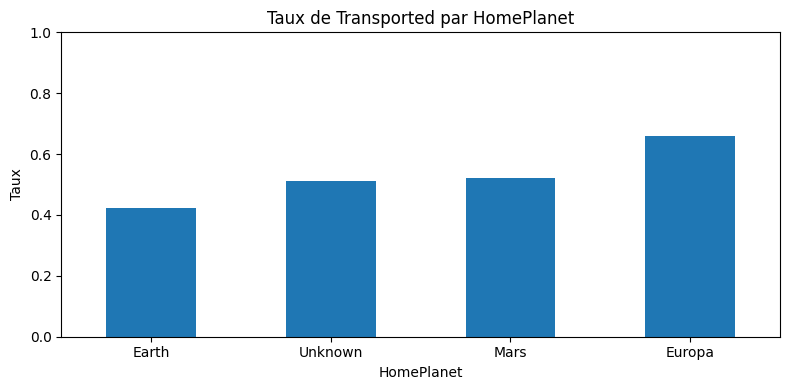

In [291]:
if df_train['Transported'].dtype == bool or df_train['Transported'].dropna().isin([True, False]).all():
    df_train['Transported'] = df_train['Transported'].astype(int)
else:
    df_train['Transported'] = df_train['Transported'].map({True:1, False:0, "True":1, "False":0}).astype(int)

df_train = df_train.copy()
df_train['HomePlanet'] = df_train['HomePlanet'].fillna("Unknown")

ct = pd.crosstab(df_train['HomePlanet'], df_train['Transported'])
ct.columns = ['Not_Transported(0)', 'Transported(1)']

rates = (ct[ 'Transported(1)'] / ct.sum(axis=1)).sort_values(ascending=False)

chi2, p, dof, expected = chi2_contingency(ct)
n = ct.values.sum()

r, c = ct.shape

plt.figure(figsize=(8,4))
rates.sort_values().plot(kind='bar', rot=0)
plt.title("Taux de Transported par HomePlanet")
plt.ylabel("Taux")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

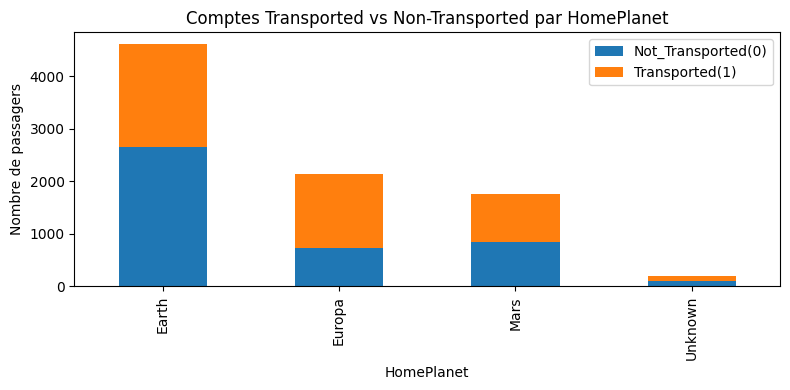

In [292]:
ct.plot(kind='bar', stacked=True, figsize=(8,4))
plt.title("Comptes Transported vs Non-Transported par HomePlanet")
plt.ylabel("Nombre de passagers")
plt.xlabel("HomePlanet")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

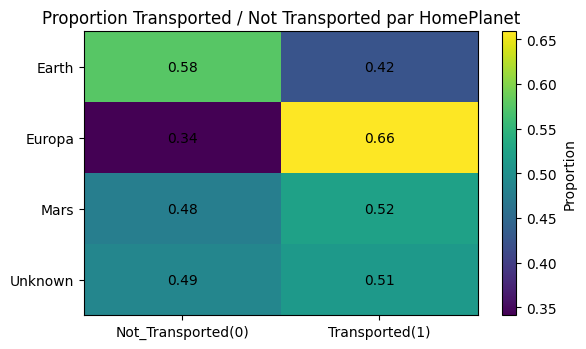

In [293]:
prop = ct.div(ct.sum(axis=1), axis=0)
plt.figure(figsize=(6,3.6))
plt.imshow(prop.values, aspect='auto')
plt.xticks(ticks=range(prop.shape[1]), labels=prop.columns)
plt.yticks(ticks=range(prop.shape[0]), labels=prop.index)
plt.colorbar(label="Proportion")
plt.title("Proportion Transported / Not Transported par HomePlanet")
for i in range(prop.shape[0]):
    for j in range(prop.shape[1]):
        plt.text(j, i, f"{prop.values[i, j]:.2f}", ha='center', va='center')
plt.tight_layout()
plt.show()

## Concatenation

In [294]:
all_df = pd.concat(
    {"train": df_train, "test": df_test},
    axis=0
).reset_index(level=0).rename(columns={"level_0": "_split"})
all_df["_is_train"] = (all_df["_split"] == "train").astype(int)


## Feature engineering

### Group from PassengerId:

We extract the number after the underscore in PassengerId to create Group. People in the same group often travel together and share similar traits.

### Total spending (Expenses) + NoSpend:

We add all spending columns (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) into one Expenses feature.
We also create NoSpend (1 if total spending is 0, else 0). This captures a strong pattern: passengers with no spending are often in cryo sleep.

### Train-aware imputations (no target leakage):

We use only the training rows to learn default values (modes/medians), then apply them to all data.
CryoSleep: if missing, set to 1 when Expenses == 0, set to 0 when Expenses > 0, otherwise use the train mode.
Age: fill using the median within (HomePlanet, Destination, CryoSleep, VIP) groups; if still missing, use the global train median.
Destination: fill with the mode per HomePlanet; if missing, try the mode per Deck; if still missing, use the global train mode.

### Type cleanup:

We convert:

Group to integer (missing → -1)
CabinNum to integer (missing → -1)
CryoSleep and VIP to 0/1 integers
Age and Expenses to floats
This keeps the data consistent and ready for modeling.

In [ ]:
all_df["Group"] = all_df["PassengerId"].astype(str).str.split("_", n=1, expand=True)[1]
all_df["Group"] = pd.to_numeric(all_df["Group"], errors="coerce")

expense_cols = [c for c in ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"] if c in all_df.columns]
for c in expense_cols:
    all_df[c] = pd.to_numeric(all_df[c], errors="coerce")
all_df["Expenses"] = all_df[expense_cols].sum(axis=1, min_count=1).fillna(0.0)
all_df["NoSpend"]  = (all_df["Expenses"] == 0).astype(int)

parts = all_df.get("Cabin", pd.Series(index=all_df.index, dtype="object")).astype(str).str.split("/", expand=True)
all_df["Deck"]     = parts[0].where(all_df["Cabin"].notna(), np.nan) if parts.shape[1] >= 1 else np.nan
all_df["CabinNum"] = pd.to_numeric(parts[1], errors="coerce") if parts.shape[1] >= 2 else np.nan
all_df["Side"]     = parts[2].where(all_df["Cabin"].notna(), np.nan) if parts.shape[1] >= 3 else np.nan

train_mask = all_df["_is_train"] == 1

cryo_mode = all_df.loc[train_mask, "CryoSleep"].mode(dropna=True)
cryo_fill = bool(cryo_mode.iloc[0]) if not cryo_mode.empty else False
all_df["CryoSleep"] = np.where(
    all_df["CryoSleep"].isna(),
    np.where(all_df["Expenses"] > 0, 0, np.where(all_df["Expenses"] == 0, 1, cryo_fill)),
    all_df["CryoSleep"]
)

vip_mode = all_df.loc[train_mask, "VIP"].mode(dropna=True)
vip_fill = bool(vip_mode.iloc[0]) if not vip_mode.empty else False
all_df["VIP"] = all_df["VIP"].fillna(vip_fill)

age_global = all_df.loc[train_mask, "Age"].median()
age_group  = all_df.groupby(["HomePlanet","Destination","CryoSleep","VIP"])["Age"].transform("median")
all_df["Age"] = np.where(all_df["Age"].isna(), age_group, all_df["Age"])
all_df["Age"] = all_df["Age"].fillna(age_global)

dest_global = all_df.loc[train_mask, "Destination"].mode(dropna=True)
dest_global = dest_global.iloc[0] if not dest_global.empty else np.nan
dest_by_hp  = all_df.groupby("HomePlanet")["Destination"].apply(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
dest_by_deck= all_df.groupby("Deck")["Destination"].apply(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
all_df["Destination"] = all_df.apply(
    lambda r: r["Destination"]
    if pd.notna(r["Destination"])
    else (dest_by_hp.get(r["HomePlanet"], np.nan) if pd.notna(dest_by_hp.get(r["HomePlanet"], np.nan))
          else (dest_by_deck.get(r["Deck"], np.nan) if pd.notna(dest_by_deck.get(r["Deck"], np.nan)) else dest_global)),
    axis=1
)

all_df["Group"]    = all_df["Group"].fillna(-1).astype(int)
all_df["CabinNum"] = all_df["CabinNum"].fillna(-1).astype(int)
all_df["CryoSleep"]= all_df["CryoSleep"].astype(bool).astype(int)
all_df["VIP"]      = all_df["VIP"].astype(bool).astype(int)
all_df["Age"]      = all_df["Age"].astype(float)
all_df["Expenses"] = all_df["Expenses"].astype(float)


## Encodage and separation train/test

In [ ]:
num_feats = ["CryoSleep","VIP","Expenses","NoSpend","Age","Group","CabinNum"]
cat_feats = [c for c in ["HomePlanet","Destination","Deck","Side"] if c in all_df.columns]

X = pd.get_dummies(all_df[num_feats + cat_feats], columns=cat_feats, dummy_na=True)
X_train = X[all_df["_is_train"] == 1]
X_test  = X[all_df["_is_train"] == 0]
y = all_df["Transported"].astype(bool).astype(int)[all_df["_is_train"] == 1]

## Train model

In [297]:
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
).fit(X_train, y)

## Prediction and submission

In [298]:
pred = rf.predict(X_test).astype(bool)
submission = pd.DataFrame({"PassengerId": test_pid, "Transported": pred})
submission.to_csv("submission.csv", index=False)

## Submission Kaggle CLI

In [299]:
home = str(pathlib.Path.home())
token_path = os.path.join(home, ".kaggle", "kaggle.json")
if os.path.exists(token_path):
    try:
        os.chmod(token_path, 0o600)
    except Exception:
        pass

cmd = f'kaggle competitions submit -c spaceship-titanic -f submission.csv -m "RF simple concat + FE propre - {datetime.datetime.now():%Y-%m-%d %H:%M}"'
subprocess.run(shlex.split(cmd), capture_output=True, text=True)

CompletedProcess(args=['kaggle', 'competitions', 'submit', '-c', 'spaceship-titanic', '-f', 'submission.csv', '-m', 'RF simple concat + FE propre - 2025-10-15 15:11'], returncode=0, stdout='Successfully submitted to Spaceship Titanic', stderr='\n  0%|          | 0.00/56.7k [00:00<?, ?B/s]\n100%|██████████| 56.7k/56.7k [00:00<00:00, 106kB/s]\n')